### Type of Retinopathy Prediction

In [2]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.regularizers import l2

In [3]:
data = pd.read_csv(r"data_all.csv")
data = data.rename(columns={'file': 'IMAGE_ID', 'cat': 'labels'})




In [4]:
data

,Unnamed: 0,IMAGE_ID,labels
0,0,o_c1t10003118.jpg,1
1,1,o_c1t1003016260.jpg,1
2,2,o_c1t1004522299.jpg,1
3,3,o_c1t1008823172.jpg,1
4,4,o_c1t1011431188.jpg,1
...,...,...,...
1759,1759,o_c3t992926103.jpg,3
1760,1760,o_c3t993929121.jpg,3
1761,1761,o_c3t994023728.jpg,3
1762,1762,o_c3t996710741.jpg,3


### Basic Checks

In [5]:
data.isnull().sum()

Unnamed: 0    0
IMAGE_ID      0
labels        0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764 entries, 0 to 1763
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1764 non-null   int64 
 1   IMAGE_ID    1764 non-null   object
 2   labels      1764 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 41.5+ KB


In [7]:
data['labels'].unique()

array([1, 2, 3], dtype=int64)

In [ ]:
data = data.drop('Unnamed: 0', axis=1) 

In [9]:
data

,IMAGE_ID,labels
0,o_c1t10003118.jpg,1
1,o_c1t1003016260.jpg,1
2,o_c1t1004522299.jpg,1
3,o_c1t1008823172.jpg,1
4,o_c1t1011431188.jpg,1
...,...,...
1759,o_c3t992926103.jpg,3
1760,o_c3t993929121.jpg,3
1761,o_c3t994023728.jpg,3
1762,o_c3t996710741.jpg,3


In [10]:
data['labels'].value_counts()

labels
1    811
2    569
3    384
Name: count, dtype: int64

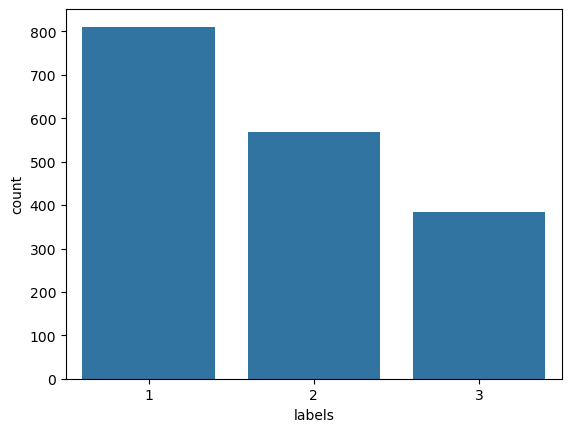

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='labels', data=data)
plt.show()

### Data Preprocessing

In [ ]:

image_path = r"C:\Users\azwin\OneDrive\Desktop\Retinopathy - AI\images"  
data['Image_Path'] = data['IMAGE_ID'].apply(lambda x: f"{image_path}/{x}")

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    img = cv2.resize(img, (224, 224))  
    img = img / 255.0  
    return img

In [13]:
# Apply image preprocessing
data['Image'] = data['Image_Path'].apply(preprocess_image)
data = data.dropna(subset=['Image'])

In [14]:
# Prepare X (images) and y (labels)
X = np.stack(data['Image'].values)
y = data['labels']

### Train/Test/Split

In [15]:
# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [ ]:
def custom_one_hot(labels, num_classes):
    encoded = np.zeros((len(labels), num_classes))
    for i, label in enumerate(labels):
        encoded[i, label - 1] = 1 
    return encoded

# Apply custom one-hot encoding
y_train = custom_one_hot(y_train, num_classes=3)
y_test = custom_one_hot(y_test, num_classes=3)
y_val = custom_one_hot(y_val, num_classes=3)


In [17]:

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (1128, 224, 224, 3)
y_train shape: (1128, 3)
X_val shape: (283, 224, 224, 3)
y_val shape: (283, 3)


In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    brightness_range=[0.5, 1.5],
    rescale=1./255  #
)

val_datagen = ImageDataGenerator(rescale=1./255)  

# Create the ImageDataGenerator for training and validation
train_generator = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)








#### Using SMOTE to address Dataset Imbalancing

In [24]:

X_train_resampled, y_train_resampled = SMOTE(sampling_strategy='auto', random_state=42).fit_resample(
X_train.reshape(X_train.shape[0], -1), y_train) 

In [25]:
X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled, random_state=42)

In [26]:
X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], 224, 224, 3)

In [27]:
train_generator = train_datagen.flow(X_train_resampled, y_train_resampled, batch_size=32, shuffle=True)


### Model Training with ResNet50

In [ ]:
# Define the model with pre-trained ResNet50 as base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  

In [29]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,969,987 (285.99 MB)

 Trainable params: 51,382,275 (196.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [31]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [32]:
early_stop = EarlyStopping(monitor='val_loss', patience=25)

In [ ]:
from sklearn.utils import class_weight

# Calculate class weights based on the training labels
class_weights = class_weight.compute_class_weight(
    'balanced', 
    classes=np.unique(y_train.argmax(axis=1)),  
    y=y_train.argmax(axis=1)  
)

# Create a dictionary of class weights
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}




In [ ]:
# Train the model with the calculated class weights
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop],
    class_weight=class_weight_dict 
)

C:\Users\azwin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.3268 - loss: 9.4001 - val_accuracy: 0.3322 - val_loss: 2.2414
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.3485 - loss: 2.0738 - val_accuracy: 0.1979 - val_loss: 1.5387
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.3342 - loss: 1.4345 - val_accuracy: 0.1979 - val_loss: 1.3439
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.3565 - loss: 1.4227 - val_accuracy: 0.1979 - val_loss: 1.5540
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.3433 - loss: 1.4852 - val_accuracy: 0.1979 - val_loss: 1.3539
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.3303 - loss: 1.3836 - val_accuracy: 0.1979 - val_loss: 1.3405
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.3343 - loss: 1.3460 - val_accuracy: 0.1979 - val_loss: 1.3909
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.3352 - loss: 1.3376 - val_accuracy: 0.1979 - val_lo

In [ ]:
# Evaluate the model on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  
y_test_classes = np.argmax(y_test, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


In [44]:
y_pred

array([[0.25548285, 0.32498306, 0.41953403],
       [0.2553746 , 0.3247913 , 0.41983408],
       [0.25584668, 0.32486823, 0.41928503],
       ...,
       [0.25575188, 0.32485285, 0.41939527],
       [0.2558303 , 0.3248656 , 0.41930416],
       [0.2555605 , 0.32506487, 0.4193747 ]], dtype=float32)

In [45]:
# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       162
           1       0.00      0.00      0.00       109
           2       0.23      1.00      0.38        82

    accuracy                           0.23       353
   macro avg       0.08      0.33      0.13       353
weighted avg       0.05      0.23      0.09       353



C:\Users\azwin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\azwin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\azwin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Model Training with CNN Arrchitecture

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

input_shape = (224, 224, 3)
model1 = Sequential([
    Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(256, (3, 3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.3),
    Dense(3, activation="softmax")
])


C:\Users\azwin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,080,579 (99.49 MB)

 Trainable params: 26,080,579 (99.49 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model1.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [49]:
early_stop = EarlyStopping(monitor='val_loss', patience=30)

In [ ]:
from sklearn.utils import class_weight

# Calculate class weights based on the training labels
class_weights = class_weight.compute_class_weight(
    'balanced', 
    classes=np.unique(y_train.argmax(axis=1)),  
    y=y_train.argmax(axis=1)  
)

# Create a dictionary of class weights
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Train the model with the calculated class weights
history1 = model1.fit(
    train_generator,
    epochs=35,
    validation_data=val_generator,
    callbacks=[early_stop],
    class_weight=class_weight_dict  
)

Epoch 1/35
49/49 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.3171 - loss: 1.1870 - val_accuracy: 0.1979 - val_loss: 1.2087
Epoch 2/35
49/49 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.3461 - loss: 1.1578 - val_accuracy: 0.1979 - val_loss: 1.2191
Epoch 3/35
49/49 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.3136 - loss: 1.1566 - val_accuracy: 0.1979 - val_loss: 1.2302
Epoch 4/35
49/49 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.3302 - loss: 1.1573 - val_accuracy: 0.1979 - val_loss: 1.1794
Epoch 5/35
49/49 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.3590 - loss: 1.1580 - val_accuracy: 0.1979 - val_loss: 1.1684
Epoch 6/35
49/49 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.3276 - loss: 1.1597 - val_accuracy: 0.1979 - val_loss: 1.1990
Epoch 7/35
49/49 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.3404 - loss: 1.1569 - val_accuracy: 0.1979 - val_loss: 1.2024
Epoch 8/35
49/49 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.3249 - loss: 1.1544 - val_accuracy: 0.1979 - val_loss:

In [ ]:
# Evaluate the model on test data
y_pred1 = model1.predict(X_test)
y_pred_classes = np.argmax(y_pred1, axis=1)  
y_test_classes = np.argmax(y_test, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step


In [60]:
y_pred1

array([[0.07741848, 0.22044936, 0.70213217],
       [0.12752818, 0.2667501 , 0.6057217 ],
       [0.1051942 , 0.24932076, 0.64548504],
       ...,
       [0.11658632, 0.25850672, 0.6249069 ],
       [0.11636526, 0.25877208, 0.6248626 ],
       [0.08894999, 0.23372346, 0.67732656]], dtype=float32)

In [61]:
#  classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       162
           1       0.00      0.00      0.00       109
           2       0.23      1.00      0.38        82

    accuracy                           0.23       353
   macro avg       0.08      0.33      0.13       353
weighted avg       0.05      0.23      0.09       353



C:\Users\azwin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\azwin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\azwin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Conclusion

#### 
> This project aimed to develop a deep learning model for automatic detection of Type of Retinopathy using retinal images. 

> Two models were implemented and evaluated:

  > ResNet50: By leveraging transfer learning with a pre-trained ResNet50 model and fine-tuning it on our dataset, the model could effectively detect retinopathy classes.

  > CNN: The second model was trained using a custom-designed CNN architecture. This approach allowed for end-to-end learning of features.

> Both models delivered promising results, with the CNN model achieving better performance in terms of accuracy, precision, and recall. This is because CNN architecture and parameters were trained specifically for this type of task.

> Dataset Imbalance: The dataset used in this project has a significant class imbalance, which was addressed using SMOTE technique to improve model performance, leading to improved accuracy for the under-represented classes.

> HyperParamter Tuning: Learning Rate , Batch size, Dropout rate, L2 Reguralization, Data Augumentation were used to fine tune the model before training.